Este trabalho é referente à disciplina de Inteligência Artificial do curso de Bacharelado em Ciência da Computação na Universidade Federal do Pará. Ele propõe a implementação de uma versão do algoritmo **_Stochastic Hill Climbing_** (**_Simulated Annealing_**) e do **_Genetic Algorithm_** para a resolução do **problema das oito rainhas**.

Integrantes:

- [201804940002] Eduardo Gil Serrão Cardoso
- [201804940016] Gabriela Souza Maximino
- [201704940007] Igor Matheus Souza Moreira

As questões propostas pelo trabalho são citadas e respondidas abaixo. Antes de interagir com o código no Jupyter Notebook/Lab, observe que certas células anteriores à que se quer executar podem ser necessárias. A fim de evitar isso, certifique-se de executar ao menos uma vez todas as células contendo definições de funções ou importações de módulos.

# Requisitos

## Ambiente

Este trabalho foi feito utilizando a seguinte linguagem de programação:

- `python` 3.8.5

Em adição, os seguintes módulos precisam estar instalados no ambiente em que este notebook for executado:

- `matplotlib` 3.3.2
- `numpy` 1.19.2
- `pandas` 1.1.4
- `seaborn` 0.11.0

Observe que o código pode funcionar em versões distintas às que foram mencionadas acima; contudo, sabe-se que a sua execução é garantida nas versões mencionadas.

In [1]:
import decimal as d
import numpy as np
import pandas as pd
import random as r
import seaborn as sns
import typing as t

from matplotlib import pyplot as plt
from timeit import default_timer as timer

## Funções de checagem

Uma vez configurado o ambiente em que este notebook será executado, hão de se ter definidas algumas funções de checagem que serão utilizadas mais adiante:

In [2]:
def verifica_comprimento_binario_igual_a(**parametros):
    numero_de_parametros = len(parametros.keys())

    if numero_de_parametros != 2:
        raise ValueError(f"Apenas um parâmetro pode ser passado para esta função. Foram recebidos {numero_de_parametros}.")

    parametro, outro_parametro = parametros.keys()

    valor, descricao = parametros[parametro]
    outro_valor, outra_descricao = parametros[outro_parametro]

    if outro_valor is not None and len(valor) != outro_valor:
        raise ValueError(f"O comprimento do {descricao} {parametro}, em binário, precisa ser igual ao {outra_descricao} {outro_parametro}.")

In [3]:
def verifica_comprimento_maior_ou_igual_a(**parametros):
    numero_de_parametros = len(parametros.keys())

    if numero_de_parametros != 2:
        raise ValueError(f"Apenas um parâmetro pode ser passado para esta função. Foram recebidos {numero_de_parametros}.")

    parametro, outro_parametro = parametros.keys()

    valor, descricao = parametros[parametro]
    outro_valor, outra_descricao = parametros[outro_parametro]

    if outro_valor is not None and len(valor) < outro_valor:
        raise ValueError(f"O {descricao} {parametro} precisa receber um valor, no mínimo, igual ao {outra_descricao} {outro_parametro}.")

In [4]:
def verifica_comprimento_menor_ou_igual_a(**parametros):
    numero_de_parametros = len(parametros.keys())

    if numero_de_parametros != 2:
        raise ValueError(f"Apenas um parâmetro pode ser passado para esta função. Foram recebidos {numero_de_parametros}.")

    parametro, outro_parametro = parametros.keys()

    valor, descricao = parametros[parametro]
    outro_valor, outra_descricao = parametros[outro_parametro]

    if outro_valor is not None and len(valor) > outro_valor:
        raise ValueError(f"O comprimento do {descricao} {parametro} precisa ser, no máximo, igual ao {outra_descricao} {outro_parametro}.")

In [5]:
def verifica_dtype(**parametro_dict):
    numero_de_parametros = len(parametro_dict.keys())

    if numero_de_parametros != 1:
        raise ValueError(f"Apenas um parâmetro pode ser passado para esta função. Foram recebidos {numero_de_parametros}.")

    parametro = list(parametro_dict.keys())[0]
    valor, descricao, dtype = parametro_dict[parametro]

    if dtype == np.int_ and valor.dtype != dtype:
        if valor.dtype == np.float_:
            return valor.astype(np.int_)
        else:
            raise TypeError(f"O {descricao} {parametro} precisa ser um numpy array com atributo dtype igual a {dtype}. O dtype do numpy array recebido é {valor.dtype}.")

    if valor.dtype != dtype:
        raise TypeError(f"O {descricao} {parametro} precisa ser um numpy array com atributo dtype igual a {dtype}. O dtype do numpy array recebido é {valor.dtype}.")
    else:
        return valor

In [6]:
def verifica_maior_ou_igual_a(**parametros):
    numero_de_parametros = len(parametros.keys())

    if numero_de_parametros != 2:
        raise ValueError(f"Apenas um parâmetro pode ser passado para esta função. Foram recebidos {numero_de_parametros}.")

    parametro, outro_parametro = parametros.keys()

    valor, descricao = parametros[parametro]
    outro_valor, outra_descricao = parametros[outro_parametro]

    if outro_valor is not None and valor < outro_valor:
        raise ValueError(f"O {descricao} {parametro} precisa receber um valor, no mínimo, igual ao {outra_descricao} {outro_parametro}.")

In [7]:
def verifica_menor_ou_igual_a(**parametros):
    numero_de_parametros = len(parametros.keys())

    if numero_de_parametros != 2:
        raise ValueError(f"Apenas um parâmetro pode ser passado para esta função. Foram recebidos {numero_de_parametros}.")

    parametro, outro_parametro = parametros.keys()

    valor, descricao = parametros[parametro]
    outro_valor, outra_descricao = parametros[outro_parametro]

    if outro_valor is not None and valor > outro_valor:
        raise ValueError(f"O {descricao} {parametro} precisa receber um valor, no máximo, igual ao {outra_descricao} {outro_parametro}.")

In [8]:
def verifica_nao_negatividade(**parametros):
    for parametro in parametros.keys():
        valor, descricao = parametros[parametro]

        if valor < 0:
            raise ValueError(f"O {descricao} {parametro} precisa receber um número não-negativo.")

In [9]:
def verifica_ndim(**parametros):
    for parametro in parametros.keys():
        valor, descricao, ndim = parametros[parametro]

        if valor.ndim != ndim:
            raise ValueError(f"O o atributo ndim do {descricao} {parametro} precisa ser igual a {ndim}.")

In [10]:
def verifica_tipo(**parametro_dict):
    numero_de_parametros = len(parametro_dict.keys())

    if numero_de_parametros != 1:
        raise ValueError(f"Apenas um parâmetro pode ser passado para esta função. Foram recebidos {numero_de_parametros}.")

    parametro = list(parametro_dict.keys())[0]
    valor, descricao, tipos = parametro_dict[parametro]

    if tipos == t.SupportsFloat:
        if not isinstance(valor, tipos):
            raise TypeError(f"O {descricao} {parametro} precisa receber um número de ponto flutuante ou um objeto que possa ser convertido para tal.")
        else:
            return float(valor)

    if tipos == t.SupportsInt:
        if not isinstance(valor, tipos):
            raise TypeError(f"O {descricao} {parametro} precisa receber um número inteiro ou um objeto que possa ser convertido para tal.")
        else:
            return int(valor)

    if tipos == np.ndarray:
        if not isinstance(valor, np.ndarray):
            if not isinstance(valor, (list, tuple)):
                raise TypeError(f"O {descricao} {parametro} precisa receber um array numpy ou um objeto que possa ser convertido para tal.")
            else:
                return np.array(valor)

    if tipos == bool:
        if not isinstance(valor, bool):
            if isinstance(valor, np.bool_):
                return bool(valor)
            else:
                raise TypeError(f"O {descricao} {parametro} precisa receber um objeto booleano ou um objeto que possa ser convertido para tal.")
        else:
            return valor

    if not isinstance(valor, tipos):
        raise TypeError(f"O {descricao} {parametro} precisa receber um objeto de classe {tipos} ou que herde dela.")
    else:
        return valor

In [11]:
def verifica_tipo_operador(operador, valor, tipo):
    if not isinstance(valor, tipo):
        raise TypeError(f"O operador '{operador}' precisa ser do tipo {tipo}.")

# Definição do Tabuleiro

Uma vez que ambos os algoritmos a serem discutidos aqui – _Simulated Annealing_ e _Genetic Algorithm_ — são utilizados para resolver o mesmo problema – o problema das oito rainhas –, optou-se por definir uma classe comumente utilizada por ambos os algoritmos, intitulada `Tabuleiro`.

## Funções auxiliares

Antes de definirmos a classe, `Tabuleiro`, precisamos de uma definição para auxiliar nas representações da classe quando o modo binário estiver ativado.

In [12]:
def ajusta_indentacao(string, string_para_adicionar):
    string = verifica_tipo(string=(string, "parâmetro", str))
    string_para_adicionar = verifica_tipo(string_para_adicionar=(string_para_adicionar, "parâmetro", str))
    
    linhas = string.split("\n")

    for linha in range(1, len(linhas)):
        linhas[linha] = string_para_adicionar + linhas[linha]

    return "\n".join(linhas)

Por fim, duas funções são necessárias para definir a conversão entre as notações suportadas.

In [13]:
def binario_para_decimal(bits):
    bits = verifica_tipo(bits=(bits, "parâmetro", np.ndarray))

    return int("".join(bits.astype(np.int_).astype(str)), base=2) - 1

In [14]:
def decimal_para_binario(numero, numero_de_bits):
    numero = verifica_tipo(numero=(numero, "parâmetro", t.SupportsInt))
    digitos_binarios = list(bin(numero + 1)[2:].zfill(numero_de_bits))

    verifica_comprimento_binario_igual_a(numero=(digitos_binarios, "parâmetro"), numero_de_bits=(numero_de_bits, "parâmetro"))

    return np.array(digitos_binarios, dtype=np.int_).astype(np.bool_)

## A classe `Tabuleiro`

Uma vez definidas as funções auxiliares, definamos agora a classe `Tabuleiro`. Alguns recursos permitidos por esta implementação incluem

- suporte às notações binária e decimal (i.e., inteira), com possibilidade de alteração entre notações após a inicialização do objeto;
- suporte a operadores e funções internas ao `python`, como `__str__`, `__repr__`, `__lt__` (`<`), `__eq__` (`=`), `__gt__` (`>`) e outras;
- verificação de ataques (i.e., a função objetivo definida para este problema);
- homogeneização das heurísticas adotadas na inicialização (no caso, não aceitar rainhas na mesma linha ou na mesma coluna);
- suporte a diferentes tamanhos de tabuleiro e números de rainhas (o que quer dizer que `Tabuleiro` representa também a _ausência_ de rainhas),

entre outros. Embora se tenha o entendimento de que alguns recursos da implementação não serão utilizados na resolução dos exercícios ora propostos (e.g., o último recurso citado), eles compõem a implementação e a tornam mais flexível, aumentando a possibilidade de reciclagem desta peça de código para outros fins.

In [15]:
class Tabuleiro:
    def __init__(self, *, binario=False, lado_tabuleiro=8, n_rainhas=8, rainhas=None):
        self.__lado_tabuleiro, self.__n_rainhas, self.__rainhas, self.__valor = None, None, None, np.inf

        self.binario = binario
        self.lado_tabuleiro = lado_tabuleiro
        self.n_rainhas = n_rainhas

        if rainhas is not None:
            self.rainhas = rainhas

    @property
    def binario(self):
        return self.__binario

    @binario.setter
    def binario(self, novo_binario):
        novo_binario = verifica_tipo(binario=(novo_binario, "atributo", (bool, np.bool_)))

        self.__binario = novo_binario

        if self.__rainhas is not None:
            if novo_binario is True:
                numero_de_casas = np.ceil(np.log2(self.lado_tabuleiro + 1)).astype(np.int_)
                self.rainhas = [decimal_para_binario(posicao, numero_de_casas) for posicao in self.rainhas]
            else:
                self.rainhas = [binario_para_decimal(posicao) for posicao in self.rainhas]

    @property
    def lado_tabuleiro(self):
        return self.__lado_tabuleiro

    @lado_tabuleiro.setter
    def lado_tabuleiro(self, novo_lado_tabuleiro):
        novo_lado_tabuleiro = verifica_tipo(lado_tabuleiro=(novo_lado_tabuleiro, "atributo", t.SupportsInt))

        verifica_nao_negatividade(lado_tabuleiro=(novo_lado_tabuleiro, "atributo"))
        verifica_maior_ou_igual_a(lado_tabuleiro=(novo_lado_tabuleiro, "atributo"), n_rainhas=(self.n_rainhas, "atributo"))

        self.__lado_tabuleiro = novo_lado_tabuleiro

    @property
    def n_rainhas(self):
        return self.__n_rainhas

    @n_rainhas.setter
    def n_rainhas(self, novo_n_rainhas):
        novo_n_rainhas = verifica_tipo(n_rainhas=(novo_n_rainhas, "atributo", t.SupportsInt))

        verifica_nao_negatividade(n_rainhas=(novo_n_rainhas, "atributo"))
        verifica_menor_ou_igual_a(n_rainhas=(novo_n_rainhas, "atributo"), lado_tabuleiro=(self.lado_tabuleiro, "atributo"))

        self.__n_rainhas = novo_n_rainhas

        self.aleatoriza_rainhas()

    def aleatoriza_rainhas(self):
        posicoes = np.random.choice(self.lado_tabuleiro, self.n_rainhas, replace=False)

        if self.binario is True:
            digitos_necessarios = np.ceil(np.log2(self.lado_tabuleiro + 1)).astype(np.int_)
            rainhas = np.empty((self.lado_tabuleiro, digitos_necessarios), dtype=np.bool_)
            rainhas[:self.n_rainhas, :] = [decimal_para_binario(posicao, digitos_necessarios) for posicao in posicoes]
            rainhas[self.n_rainhas:, :] = np.False_
        else:
            rainhas = np.empty(self.lado_tabuleiro, dtype=np.int_)

            rainhas[:self.n_rainhas] = posicoes
            rainhas[self.n_rainhas:] = -1

        self.rainhas = rainhas

    @property
    def rainhas(self):
        return self.__rainhas.copy() if self.__rainhas is not None else None

    @rainhas.setter
    def rainhas(self, novo_rainhas):
        novo_rainhas = verifica_tipo(rainhas=(novo_rainhas, "atributo", np.ndarray))

        verifica_comprimento_menor_ou_igual_a(rainhas=(novo_rainhas, "atributo"), lado_tabuleiro=(self.lado_tabuleiro, "atributo"))

        if self.binario is True:
            novo_rainhas = verifica_dtype(rainhas=(novo_rainhas, "atributo", np.bool_))

            verifica_ndim(rainhas=(novo_rainhas, "atributo", 2))

            if novo_rainhas.shape[0] < self.lado_tabuleiro:
                diferenca = self.lado_tabuleiro - novo_rainhas.shape[0]
                novo_rainhas = np.concatenate((novo_rainhas, diferenca * [[np.False_, np.False_, np.False_]]))
        else:
            novo_rainhas = verifica_dtype(rainhas=(novo_rainhas, "atributo", np.int_))

            verifica_ndim(rainhas=(novo_rainhas, "atributo", 1))

            if novo_rainhas.shape[0] < self.lado_tabuleiro:
                diferenca = self.lado_tabuleiro - novo_rainhas.shape[0]
                novo_rainhas = np.append(novo_rainhas, diferenca * [-1])

        self.__rainhas = novo_rainhas

        self.calcula_valor()

    def calcula_valor(self):
        ataques = 0

        for indice_rainha in range(self.n_rainhas):
            for indice_prox_rainha in range(indice_rainha + 1, self.n_rainhas):
                ataques += self.ha_ataque(indice_rainha, indice_prox_rainha)  
                
        self.__valor = ataques

    @property
    def valor(self):
        return self.__valor

    def ha_ataque(self, indice_a, indice_b):
        if self.binario is True:
            iterador = (binario_para_decimal(posicao) for posicao in self.rainhas)
            rainhas = np.fromiter(iterador, np.int_, self.n_rainhas)
        else:
            rainhas = self.rainhas

        indice_a = verifica_tipo(indice_a=(indice_a, "parâmetro", t.SupportsInt))
        indice_b = verifica_tipo(indice_b=(indice_b, "parâmetro", t.SupportsInt))

        ha_ataque_horizontal = rainhas[indice_a] == rainhas[indice_b]
        ha_ataque_diagonal = (indice_b - indice_a) == abs(rainhas[indice_b] - rainhas[indice_a])

        return ha_ataque_horizontal or ha_ataque_diagonal

    @property
    def ha_rainhas_na_mesma_linha(self):
        if self.binario is True:
            iterador = (binario_para_decimal(posicao) for posicao in self.rainhas)
            rainhas = np.fromiter(iterador, np.int_, self.n_rainhas)
        else:
            rainhas = self.rainhas

        rainhas = rainhas[rainhas != -1]

        return True if rainhas.shape[0] != np.unique(rainhas).shape[0] else False

    def __sub__(self, outro):
        verifica_tipo_operador('-', outro, Tabuleiro)

        return self.valor - outro.valor

    def __lt__(self, outro):
        verifica_tipo_operador('<', outro, Tabuleiro)

        return self.valor < outro.valor

    def __gt__(self, outro):
        verifica_tipo_operador('>', outro, Tabuleiro)

        return self.valor > outro.valor

    def __eq__(self, outro):
        verifica_tipo_operador('==', outro, Tabuleiro)

        return self.valor == outro.valor

    def __repr__(self):
        if self.binario is False:
            representacao_rainhas = str(self.rainhas)
            tipo = "Decimal"
        else:
            representacao_rainhas = caixinha.ajusta_indentacao(str(self.rainhas), 12 * ' ')
            tipo = "Binário"

        return f"[Tabuleiro] {representacao_rainhas} | {self.valor} ataques | {tipo}"

    def __str__(self):
        if self.binario is False:
            return str(self.rainhas.tolist())
        else:
            representacao = []

            for rainha in self.rainhas:
                string = ""

                for bit in rainha:
                    if bit is np.True_:
                        string += "1"
                    else:
                        string += "0"

                representacao.append(string)

            return str(representacao).replace("'", "")

    def __len__(self):
        return self.n_rainhas

# Problemas

Com o auxílio das definições-suporte supra-expostas, podemos seguir para as que dizem respeito aos algoritmos _per se_. Antes de fazê-lo, contudo, é necessário que definamos uma função para os experimentos que serão conduzidos, a fim de se produzirem as tabelas, gráficos e informações estipulados em algumas alíneas desta atividade.

In [16]:
def executa_experimento(funcao, n_execucoes=50, verboso=True):
    n_execucoes = verifica_tipo(n_execucoes=(n_execucoes, "parâmetro", t.SupportsInt))
    verboso = verifica_tipo(verboso=(verboso, "parâmetro", (bool, np.bool_)))
    
    melhores_solucoes = np.empty((n_execucoes, 1), dtype=np.object_)
    melhores_valores = np.empty((n_execucoes, 1), dtype=np.int_)
    tempos_gastos = np.empty((n_execucoes, 1), dtype=np.float_)
    iteracoes_gastas = np.empty((n_execucoes, 1), dtype=np.int_)

    for e in range(n_execucoes):
        if verboso is True:
            print(f"Execução {e + 1}...", end="\r")

        tempos_gastos[e, 0] = timer()
        melhores_solucoes[e, 0], iteracoes_gastas[e, 0] = funcao()
        tempos_gastos[e, 0] = timer() - tempos_gastos[e, 0]
        melhores_valores[e, 0] = melhores_solucoes[e, 0].valor
        melhores_solucoes[e, 0] = str(melhores_solucoes[e, 0])

    tabela = np.concatenate((melhores_solucoes, melhores_valores, tempos_gastos, iteracoes_gastas), axis=1)
    tabela = pd.DataFrame(tabela, columns=["Solução", "Função-objetivo", "Tempo (segundos)", "Iterações"]).infer_objects()

    figura, eixos = plt.subplots(1, 2, figsize=(10, 5))
    
    figura.tight_layout()
    eixos[0].set_xlim(1, 50)
    eixos[1].set_xlim(1, 50)

    figura.suptitle(f"Dados da execução do algoritmo {str(funcao).split(' ')[1]}", y=1.05)

    eixos[0].set_title("Iterações mínimas por execução")
    eixos[1].set_title("Tempo mínimo por execução (em segundos)")

    sns.lineplot(x=range(1, n_execucoes + 1), y=iteracoes_gastas.ravel(), ax=eixos[0])
    sns.lineplot(x=range(1, n_execucoes + 1), y=tempos_gastos.ravel(), ax=eixos[1])

    if verboso is True:
        print(f"Execução concluída.")

    return tabela, figura

## _Stochastic Hill Climbing: Simulated Annealing_

Para resolver a primeira questão, que diz respeito ao _Stochastic Hill Climbing_, optamos por implementar o _Simulated Annealing_.

### Implementação do algoritmo

Antes de seguirmos à resolução para as alíneas referentes a este algoritmo, definamos algumas funções.

#### Funções auxiliares

Uma função auxiliar necessária precisa produzir um vetor com as temperaturas a serem iteradas pelo algoritmo.

In [17]:
def gera_temperaturas(temperatura_inicial, variacao):
    temperatura_inicial = verifica_tipo(temperatura_inicial=(temperatura_inicial, "parâmetro", t.SupportsFloat))
    variacao = verifica_tipo(variacao=(variacao, "parâmetro", t.SupportsFloat))
    
    n_iteracoes = np.round(np.floor(temperatura_inicial / variacao))
    temperaturas = temperatura_inicial - variacao * np.arange(n_iteracoes)

    return temperaturas

Por fim, uma segunda função auxiliar é necessária para definir se o algoritmo deve ir para uma solução pior.

In [18]:
def tabuleiro_deve_mudar(temperatura, variacao):
    temperatura = verifica_tipo(temperatura=(temperatura, "parâmetro", t.SupportsFloat))
    variacao = verifica_tipo(variacao=(variacao, "parâmetro", t.SupportsFloat))
    e = float(np.e)

    exp = d.Decimal(d.Decimal(e) ** (d.Decimal(variacao) / d.Decimal(temperatura)))

    return np.random.uniform() < exp

#### Algoritmo principal

Com base nas definições acima, definamos agora o algoritmo principal.

In [19]:
def recozimento_simulado(temperatura_inicial=100, variacao=.01, binario=False, verboso=False):
    temperatura_inicial = verifica_tipo(temperatura_inicial=(temperatura_inicial, "parâmetro", t.SupportsFloat))
    variacao = verifica_tipo(variacao=(variacao, "parâmetro", t.SupportsFloat))
    verboso = verifica_tipo(verboso=(verboso, "parâmetro", (bool, np.bool_)))

    verifica_menor_ou_igual_a(variacao=(variacao, "parâmetro"), temperatura_inicial=(temperatura_inicial, "parâmetro"))

    tabuleiro_atual = Tabuleiro(binario=binario)
    temperaturas = gera_temperaturas(temperatura_inicial, variacao)

    if verboso is True:
        print(f"[Iteração -1] {tabuleiro_atual}")

    if tabuleiro_atual.valor == 0:
        return tabuleiro_atual, 0

    for iteracao, temperatura in enumerate(temperaturas):
        tabuleiro_seguinte = Tabuleiro(binario=binario)

        if tabuleiro_seguinte.valor == 0:
            return tabuleiro_seguinte, iteracao + 1

        variacao = tabuleiro_atual - tabuleiro_seguinte
        
        if variacao > 0:
            tabuleiro_atual = tabuleiro_seguinte
        elif tabuleiro_deve_mudar(temperatura, variacao):
            tabuleiro_atual = tabuleiro_seguinte

        if verboso is True:
            print(f"[Iteração {iteracao}] {tabuleiro_atual} [Temperatura {np.round(temperatura, 3)}]")

    if verboso is True:
        print("A temperatura chegou a zero.")

    return tabuleiro_atual

### Descreva a função objetivo utilizada na modelagem do problema.

A função objetivo utilizada, retornada por `Tabuleiro.valor` e calculada em `Tabuleiro.calcula_valor()`, verifica a existência de ataques de rainhas no tabuleiro na horizontal e na diagonal. Sua representação é mostrada abaixo:

`ha_ataque_horizontal = rainhas[indice_a] == rainhas[indice_b]`

`ha_ataque_diagonal = (indice_b - indice_a) == abs(rainhas[indice_b] - rainhas[indice_a])`

Dado que o tabuleiro é representado por um vetor com $n$ elementos tal que o valor de cada elemento da posição $i$ representa a linha onde a rainha se encontra nessa mesma coluna, percorre-se esse vetor varrendo para cada elemento da posição `indice_a` os elementos seguintes que estão na posição `indice_b`. Caso algum tipo de ataque seja detectado, soma-se 1 ao valor do tabuleiro.

### Descreva a codificação utilizada para a solução candidata.

Para esse algoritmo, utilizou-se a codificação decimal (i.e., inteira). Contudo, graças ao suporte tanto à notação decimal quanto binária por parte da classe `Tabuleiro` e à simplicidade deste algoritmo, pode-se utilizar também a decimal ao regular o parâmetro `binario` da função `recozimento_simulado()`.

### Descreva a(s) heurística(s) e o(s) critério(s) de parada utilizados pelo algoritmo.

Como conhecimento prévio estipulado pelo projetista, foi estipulado que as rainhas não podem estar em uma mesma coluna ou linha.

No que diz respeito às condições de parada, adotaram-se dois critérios:
1. a temperatura chegar a zero (i.e., percorrer todo o vetor de _arrays_ de temperaturas, cujo tamanho depende da temperatura inicial e variação); e
2. o número de ataques chegar a zero (i.e., verificar que `tabuleiro_atual.valor == 0` ou que `tabuleiro_seguinte.valor == 0`).

### Execute 50 vezes o algoritmo.

**Calcule:**

- **Média e desvio padrão do número mínimo de iterações necessário para parar o algoritmo.**
- **Média e desvio padrão do tempo de execução do algoritmo.**

**Plote:**

- **Curva com número mínimo de iterações de cada execução.**
- **Curva com o tempo de execução do algoritmo de cada execução.**

**Mostre:**

- **Ao menos duas soluções distintas encontradas pelo algoritmo.**

Podemos obter os resultados pedidos através da função `executa_experimento()`, passando `recozimento_simulado()` pelo parâmetro `funcao`.

Execução concluída.


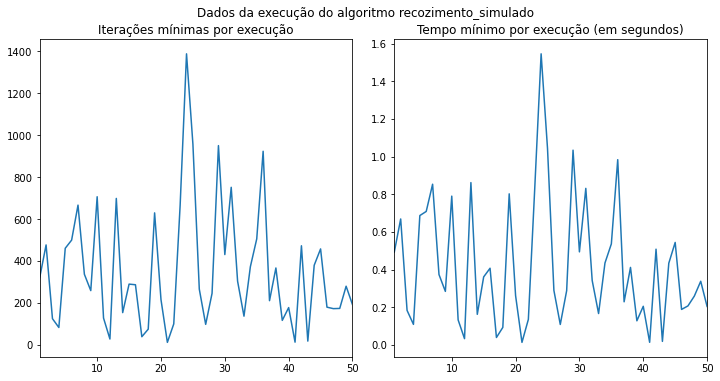

In [20]:
tabelaSA, figuraSA = executa_experimento(recozimento_simulado)

In [21]:
tabelaSA

,Solução,Função-objetivo,Tempo (segundos),Iterações
0,"[2, 5, 7, 0, 3, 6, 4, 1]",0,0.492867,320
1,"[4, 6, 3, 0, 2, 7, 5, 1]",0,0.668490,476
2,"[3, 7, 0, 4, 6, 1, 5, 2]",0,0.183071,124
3,"[4, 0, 7, 5, 2, 6, 1, 3]",0,0.108823,82
4,"[1, 6, 2, 5, 7, 4, 0, 3]",0,0.686638,460
5,"[3, 6, 0, 7, 4, 1, 5, 2]",0,0.708437,499
6,"[1, 3, 5, 7, 2, 0, 6, 4]",0,0.853028,666
7,"[5, 2, 6, 1, 3, 7, 0, 4]",0,0.373419,336
8,"[1, 7, 5, 0, 2, 4, 6, 3]",0,0.283999,258
9,"[1, 6, 2, 5, 7, 4, 0, 3]",0,0.789793,706


In [22]:
print(f"Média e desvio padrão da função-objetivo: {tabelaSA['Função-objetivo'].mean()} ± {tabelaSA['Função-objetivo'].std()} ataques\n"
      f"Média e desvio padrão do tempo gasto: {np.round(tabelaSA['Tempo (segundos)'].mean(), 3)} ± {np.round(tabelaSA['Tempo (segundos)'].std(), 3)} segundos\n"
      f"Média e desvio padrão das iterações gastas: {np.round(tabelaSA['Iterações'].mean(), 3)} ± {np.round(tabelaSA['Iterações'].std(), 3)}")

Média e desvio padrão da função-objetivo: 0.0 ± 0.0 ataques
Média e desvio padrão do tempo gasto: 0.421 ± 0.335 segundos
Média e desvio padrão das iterações gastas: 355.2 ± 293.189


### Comente e mostre o código fonte do algoritmo desenvolvido.

## _Genetic Algorithm_

### Implementação do algoritmo

Antes de seguirmos à resolução para as alíneas referentes a este algoritmo, definamos algumas funções.

#### Funções auxiliares

Uma definição é necessária para auxiliar na exibição da evolução do algoritmo quando `verboso = True`.

In [23]:
def gera_contagem_populacao(populacao):
    ataques = [tabuleiro.valor for tabuleiro in populacao]

    colunas = np.unique(ataques)
    indices = ["Contagem"]

    contagem_de_valores = {ataque: 0 for ataque in colunas}

    for ataque in ataques:
        contagem_de_valores[ataque] += 1

    data_frame = pd.DataFrame(contagem_de_valores, columns=colunas, index=indices)
    data_frame.columns.names = ["Ataques"]

    return data_frame

Em adição, uma função é requerida para inicializar a população.

In [24]:
def inicializa_populacao(tamanho_populacao):
    populacao = [Tabuleiro(binario=True) for _ in range(tamanho_populacao)]

    return sorted(populacao)

Em seguida, definições que aplicam os operadores evolucionários são necessárias.

In [25]:
def selecao_dos_pais(populacao, tamanho_ringue):
    nova_populacao, tamanho_populacao = [], len(populacao)

    for _ in range(tamanho_populacao):
        lutadores = r.sample(populacao, tamanho_ringue)
        lutadores = sorted(lutadores)

        nova_populacao.append(lutadores[0])

    return nova_populacao

In [26]:
def cruzamento(populacao, taxa_crossover):
    nova_populacao, tamanho_populacao = [], len(populacao)
    n_rodadas = np.ceil(tamanho_populacao / 2).astype(np.int_)

    for _ in range(n_rodadas):
        pai1, pai2 = r.sample(populacao, 2)
        pai1, pai2 = pai1.rainhas, pai2.rainhas

        if np.random.uniform() <= taxa_crossover:
            corte = r.randint(1, len(pai1) - 1)

            filho1 = np.concatenate((pai1[:corte], pai2[corte:]))
            filho2 = np.concatenate((pai2[:corte], pai1[corte:]))
        else:
            filho1, filho2 = pai1, pai2

        filho1, filho2 = Tabuleiro(binario=True, rainhas=filho1), Tabuleiro(binario=True, rainhas=filho2)

        if tamanho_populacao - len(nova_populacao) >= 2:
            nova_populacao.extend([filho1, filho2])
        else:
            nova_populacao.append(filho1 if np.random.uniform() <= .5 else filho2)

    return nova_populacao

In [27]:
def mutacao(populacao, taxa_mutacao):
    nova_populacao, tamanho_populacao = [], len(populacao)

    for i in range(tamanho_populacao):
        rainhas = populacao[i].rainhas

        for bit in range(rainhas.ravel().shape[0]):
            if np.random.uniform() <= taxa_mutacao:
                rainhas.ravel()[bit] = not rainhas.ravel()[bit]

        novo_tabuleiro = Tabuleiro(binario=True, rainhas=rainhas)

        nova_populacao.append(novo_tabuleiro)

    return nova_populacao

In [28]:
def seleciona_sobreviventes(populacao, nova_populacao):
    sobreviventes = sorted(populacao + nova_populacao)

    return sobreviventes[:len(populacao)]

Em seguida, uma função que assegura que os filhos estão respeitando as heurísticas estipuladas (nenhuma rainha na mesma linha) é definida.

In [29]:
def gera_filhos_validos(pais, taxa_crossover, taxa_mutacao):
    filhos, tamanho_populacao = [], len(pais)

    while len(filhos) < tamanho_populacao:
        embrioes = cruzamento(pais, taxa_crossover)
        fetos = mutacao(embrioes, taxa_mutacao)

        for feto in fetos:
            if len(filhos) < tamanho_populacao:
                if feto.ha_rainhas_na_mesma_linha is False:
                    filhos.append(feto)
            else:
                break

    return filhos

Por fim, uma solução que gera a nova população é definida.

In [30]:
def gera_nova_populacao(populacao, taxa_crossover, taxa_mutacao, tamanho_ringue):
    pais = selecao_dos_pais(populacao, tamanho_ringue)
    filhos = gera_filhos_validos(pais, taxa_crossover, taxa_mutacao)

    return sorted(filhos)

#### Algoritmo principal

Com base nas definições acima, definamos agora o algoritmo principal.

In [31]:
def algoritmo_genetico(tamanho_populacao=20, max_iteracoes=1000, taxa_mutacao=.03, taxa_crossover=.8, tamanho_ringue=3, verboso=False):
    tamanho_populacao = verifica_tipo(tamanho_populacao=(tamanho_populacao, "parâmetro", t.SupportsInt))
    max_iteracoes = verifica_tipo(max_iteracoes=(max_iteracoes, "parâmetro", t.SupportsInt))
    taxa_mutacao = verifica_tipo(taxa_mutacao=(taxa_mutacao, "parâmetro", t.SupportsFloat))
    taxa_crossover = verifica_tipo(taxa_crossover=(taxa_crossover, "parâmetro", t.SupportsFloat))
    tamanho_ringue = verifica_tipo(tamanho_do_ringue=(tamanho_ringue, "parâmetro", t.SupportsInt))
    verboso = verifica_tipo(verboso=(verboso, "parâmetro", (bool, np.bool_)))

    verifica_nao_negatividade(tamanho_populacao=(tamanho_populacao, "parâmetro"), max_iteracoes=(max_iteracoes, "parâmetro"), taxa_mutacao=(taxa_mutacao, "parâmetro"), taxa_crossover=(taxa_crossover, "parâmetro"), tamanho_ringue=(tamanho_ringue, "parâmetro"))
    verifica_menor_ou_igual_a(taxa_mutacao=(taxa_mutacao, "parâmetro"), valor=(1, "valor"))
    verifica_menor_ou_igual_a(taxa_mutacao=(taxa_crossover, "parâmetro"), valor=(1, "valor"))
    verifica_menor_ou_igual_a(tamanho_ringue=(tamanho_ringue, "parâmetro"), tamanho_populacao=(tamanho_populacao, "parâmetro"))

    pais = inicializa_populacao(tamanho_populacao)
    iteracao = 0

    if verboso is True:
        print(f"[Iteração {iteracao}] População inicial: \n"
              f"{gera_contagem_populacao(pais)}", end="\n\n")

    while iteracao < max_iteracoes:
        if pais[0].valor == 0:
            if verboso is True:
                print("Uma solução ótima foi encontrada.")

            break

        filhos = gera_nova_populacao(pais, taxa_crossover, taxa_mutacao, tamanho_ringue)
        pais = seleciona_sobreviventes(pais, filhos)
        iteracao += 1

        if verboso is True:
            print(f"[Iteração {iteracao}]\n"
                  f"Filhos: \n"
                  f"{gera_contagem_populacao(filhos)}\n\n"
                  f"Sobreviventes: \n"
                  f"{gera_contagem_populacao(pais)}", end="\n\n")

    if iteracao >= max_iteracoes and verboso is True:
        print("O número máximo de iterações foi atingido.")

    return pais[0], iteracao

### Descreva a função objetivo utilizada na modelagem do problema.

A função objetivo utilizada, retornada por `Tabuleiro.valor` e calculada em `Tabuleiro.calcula_valor()`, verifica a existência de ataques de rainhas no tabuleiro na horizontal e na diagonal. Sua representação é mostrada abaixo:

`ha_ataque_horizontal = rainhas[indice_a] == rainhas[indice_b]`

`ha_ataque_diagonal = (indice_b - indice_a) == abs(rainhas[indice_b] - rainhas[indice_a])`

Dado que o tabuleiro é representado por um vetor com $n$ elementos tal que o valor de cada elemento da posição $i$ representa a linha onde a rainha se encontra nessa mesma coluna, percorre-se esse vetor varrendo para cada elemento da posição `indice_a` os elementos seguintes que estão na posição `indice_b`. Caso algum tipo de ataque seja detectado, soma-se 1 ao valor do tabuleiro.

### Apresente a escolha e explique o funcionamento dos operadores que foram utilizados: seleção dos pais, cruzamento e mutação.

- Para a **seleção dos pais**, utilizou-se a técnica **_n-Way Tournament Selection_**, em que são selecionados _n_ indivíduos aleatórios da população para "lutar" entre si, ganhando o que tiver melhor _fitness_. Por padrão, _n_ é definido como 3. O torneio acontece duas vezes: uma para selecionar o primeiro pai e a segunda para selecionar o segundo.
- Para o **cruzamento**, utilizou-se a técnica de **cruzamento com ponto de corte aleatório**. Nessa técnica, uma posição aleatória _c_ do vetor é escolhida como ponto de corte. Quando a taxa de _crossover_ não é ultrapassada, corta-se o vetor do pai 1 da posição inicial até a posição _c_ e o vetor do pai 2 de _c_ até a última posição. Os cortes são concatenados gerando o filho 1, e o restante dos vetores "cortados" também são concatenados para gerar o filho 2. Caso a taxa de crossover seja ultrapassada, os pais tornam-se os filhos.
- Para a **mutação**, utilizou-se a técnica de **mutação com permutação aleatória**. Nessa técnica, duas posições do vetor são escolhidas aleatoriamente para serem permutadas, caso a taxa de mutação não seja ultrapassa. Caso seja, a mutação não ocorre.

### Execute 50 vezes o algoritmo.

**Calcule:**

- **Média e desvio padrão do número mínimo de iterações necessário para parar o algoritmo.**
- **Média e desvio padrão do tempo de execução do algoritmo.**

**Plote:**

- **Curva com número mínimo de iterações de cada execução.**
- **Curva com o tempo de execução do algoritmo de cada execução.**

**Mostre:**

- **Ao menos duas soluções distintas encontradas pelo algoritmo.**

Execução concluída.


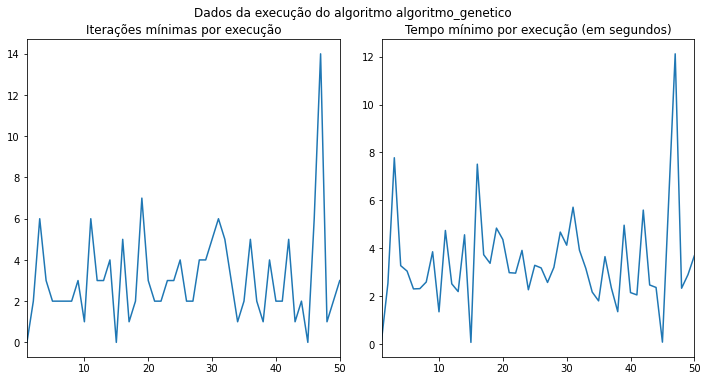

In [32]:
tabelaAG, figuraAG = executa_experimento(algoritmo_genetico)

In [33]:
tabelaAG

,Solução,Função-objetivo,Tempo (segundos),Iterações
0,"[0010, 0111, 0011, 0110, 1000, 0101, 0001, 0100]",0,0.157752,0
1,"[0011, 0001, 0111, 0100, 0010, 1110, 1000, 0110]",0,2.544151,2
2,"[0001, 1101, 0010, 0110, 1111, 0111, 1010, 0100]",0,7.778474,6
3,"[0010, 0110, 1010, 0001, 1101, 0100, 0000, 0111]",0,3.274659,3
4,"[0101, 0010, 1010, 0011, 0111, 0100, 1111, 0001]",0,3.048339,2
5,"[1000, 0010, 0111, 0011, 1101, 0000, 0100, 0110]",0,2.305371,2
6,"[0011, 0101, 1110, 1000, 0001, 0111, 1101, 0010]",0,2.315983,2
7,"[1110, 0011, 0111, 0100, 0010, 1000, 0101, 0001]",0,2.592270,2
8,"[0101, 0000, 0110, 1010, 0010, 1011, 0001, 0111]",0,3.855009,3
9,"[0001, 1101, 0110, 0000, 0011, 0111, 0100, 1100]",0,1.349079,1


In [34]:
print(f"Média e desvio padrão da função-objetivo: {tabelaAG['Função-objetivo'].mean()} ± {tabelaAG['Função-objetivo'].std()} ataques\n"
      f"Média e desvio padrão do tempo gasto: {np.round(tabelaAG['Tempo (segundos)'].mean(), 3)} ± {np.round(tabelaAG['Tempo (segundos)'].std(), 3)} segundos\n"
      f"Média e desvio padrão das iterações gastas: {np.round(tabelaAG['Iterações'].mean(), 3)} ± {np.round(tabelaAG['Iterações'].std(), 3)}")

Média e desvio padrão da função-objetivo: 0.0 ± 0.0 ataques
Média e desvio padrão do tempo gasto: 3.426 ± 2.034 segundos
Média e desvio padrão das iterações gastas: 3.1 ± 2.323


### Comente e mostre o código fonte do algoritmo desenvolvido.